# Phase 1: Tropical Cyclone Damage Assesment
## Part two:
- In this part we are going to train our model and analize the results.

In [1]:
%pip install ultralytics
!pip install opencv-python-headless 
!pip install labelme2yolo

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image #procesamiento de imagenes

# Model Building
import ultralytics
from ultralytics import YOLO
import labelme2yolo

# Others
import os
import shutil
import zipfile

%matplotlib inline

#### Generating Train and Test Data along with Configuration File

In [3]:
#!labelme2yolo --json_dir ./LABEL

### Model Training

In [4]:
#Loading the model
model = YOLO('yolov8m-obb.pt')
# Display model information (optional)
model.info()

  0%|          | 0.00/133M [00:00<?, ?B/s]

YOLOv8x-obb summary: 390 layers, 69493056 parameters, 0 gradients, 264.0 GFLOPs


(390, 69493056, 0, 263.96990719999997)

In [5]:
results = model.train(data='./dataset.yaml', epochs=85, imgsz=640)

Ultralytics YOLOv8.1.24 🚀 Python-3.9.13 torch-1.12.1.post200 CUDA:0 (Tesla T4, 15978MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=obb, mode=train, model=yolov8x-obb.pt, data=./dataset.yaml, epochs=80, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

AMP: checks passed ✅


train: Scanning /home/jovyan/EY Challenge/datasets/train.cache... 316 images, 2 backgrounds, 0 corrupt: 100%|██████████| 316/316 [00:00<?, ?it/s]
val: Scanning /home/jovyan/EY Challenge/datasets/val.cache... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<?, ?it/s]


Plotting labels to runs/obb/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 103 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/obb/train
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      13.4G      1.402      3.045      2.136        245        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]

                   all         28        297      0.382      0.652      0.274      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80        14G      1.006      1.685       1.65        245        640: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         28        297      0.238      0.519      0.299      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80        14G     0.9628      1.466      1.633        211        640: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         28        297      0.249      0.574      0.336      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      14.1G     0.8993      1.298       1.62        223        640: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         28        297      0.366      0.575       0.47      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      14.1G     0.8961       1.35       1.66        202        640: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         28        297      0.426      0.483      0.447      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      14.1G     0.8619      1.241      1.666        288        640: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         28        297      0.381      0.646      0.415      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      14.1G     0.8162      1.135      1.576        189        640: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         28        297      0.372       0.64       0.42      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      14.1G     0.8256      1.091      1.612        205        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         28        297      0.351       0.63      0.442      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      14.1G     0.7955      1.055      1.567        189        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         28        297      0.501      0.466      0.478      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80        14G     0.7617     0.9784       1.58        182        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         28        297      0.383      0.561      0.452      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      14.1G     0.7569     0.9584      1.522        302        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         28        297      0.546      0.433      0.472      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      14.1G       0.72     0.8824      1.535        171        640: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         28        297      0.496       0.44       0.47      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      14.1G     0.7395     0.8771      1.559        186        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         28        297      0.387       0.51      0.444      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80        14G     0.7144     0.8291      1.558        179        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         28        297      0.331      0.547      0.434      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      14.1G     0.6976     0.8154       1.56        204        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         28        297      0.409        0.6      0.473       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      14.1G     0.7015     0.7937      1.546        232        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         28        297      0.439       0.46      0.448      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      14.1G      0.678     0.7555      1.535        137        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         28        297      0.529      0.501      0.526      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      14.1G     0.6681      0.715      1.542        227        640: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         28        297      0.415      0.548      0.465      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      14.1G     0.6443     0.6971      1.506        295        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         28        297      0.604      0.433      0.461      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      14.1G     0.6395     0.6658      1.489        192        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         28        297      0.692      0.385      0.463      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      14.1G     0.6316      0.642       1.51        211        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         28        297      0.529       0.56      0.568      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      14.1G     0.6076     0.6206       1.52        179        640: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.431      0.599      0.528      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      14.1G     0.6142     0.6058      1.491        231        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         28        297      0.429      0.578      0.472      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      14.1G     0.6146     0.6134      1.507        232        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         28        297      0.447      0.676      0.517      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      14.1G     0.6002      0.565       1.52        216        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.473       0.62      0.508       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      14.1G     0.5736      0.523      1.477        241        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         28        297      0.511      0.497      0.491      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      14.1G     0.5763     0.5352      1.523        167        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.477      0.497      0.485      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      14.1G     0.5586     0.5142      1.499        216        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         28        297      0.535      0.542      0.502      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      14.1G     0.5746     0.5128        1.5        172        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297       0.47      0.547      0.494      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      14.1G     0.5614     0.4875      1.475        302        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.448      0.523      0.495      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80        14G     0.5559     0.4972      1.485        202        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         28        297      0.468      0.482      0.444      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      14.1G     0.5473     0.4662      1.464        209        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.444      0.541      0.471      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80        14G     0.5316     0.4722      1.473        188        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.449      0.545      0.529      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80        14G     0.5076     0.4326      1.473        200        640: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         28        297      0.602      0.433      0.525      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      14.1G     0.4999     0.4364      1.488        153        640: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.455      0.561      0.482      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      14.1G      0.501     0.4217      1.489        143        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.591       0.39      0.471      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80        14G      0.493     0.4072      1.454        215        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.487      0.459      0.451      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80        14G     0.4911     0.4045      1.481        195        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.484      0.457      0.462      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      14.1G     0.4743     0.3929      1.478        187        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.589      0.449      0.499      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80        14G     0.4792        0.4      1.471        217        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         28        297      0.501      0.453      0.467      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80        14G     0.4578      0.379      1.424        157        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.613      0.447      0.532      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80        14G     0.4652     0.3804      1.445        149        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297        0.5      0.467      0.492      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      14.1G     0.4589     0.3752      1.469        196        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.476      0.529      0.494      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      14.1G     0.4705     0.3965      1.488        180        640: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.474      0.513      0.489      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80        14G     0.4481      0.363      1.443        194        640: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         28        297      0.475       0.53      0.458       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      14.1G     0.4496     0.3676      1.447        122        640: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.431      0.607      0.508      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      14.1G     0.4384     0.3463      1.444        183        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.619      0.458      0.515      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80        14G     0.4256     0.3383      1.462        170        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.452      0.541      0.499      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      14.1G     0.4225      0.333      1.435        162        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.441      0.549      0.461      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      14.1G     0.4095       0.33      1.418        196        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.437      0.571      0.477      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80        14G     0.4068     0.3238      1.437        159        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.422      0.491      0.481      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      14.1G     0.3969     0.3107      1.404        175        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.553      0.496      0.527      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80        14G     0.4052     0.3208      1.413        213        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.499      0.452      0.487      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      14.1G      0.401     0.3123      1.428        180        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.503      0.512      0.487      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      14.1G     0.3937     0.3093      1.422        154        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         28        297      0.528      0.507      0.509      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      14.1G       0.39     0.3069      1.428        181        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.431      0.488      0.451      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      14.1G      0.389     0.3004      1.442        260        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         28        297      0.464      0.523      0.477      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      14.1G     0.4005     0.3131      1.465        240        640: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.454      0.596      0.484      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80        14G     0.3723     0.2935      1.421        214        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.473       0.52      0.503      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80        14G     0.3813     0.3045      1.433        136        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.454      0.529      0.459       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      14.1G     0.3648     0.2851      1.425        189        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         28        297      0.485      0.506      0.482      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      14.1G     0.3544     0.2886      1.424        214        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         28        297      0.475      0.483      0.476      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      14.1G     0.3564     0.2851      1.426        149        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.528      0.468      0.493      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      14.1G     0.3538     0.2839       1.43        210        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.491      0.529      0.498      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      14.1G     0.3453     0.2725      1.408        162        640: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         28        297      0.464      0.561      0.496      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      14.1G     0.3531     0.2883      1.437        249        640: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         28        297      0.498      0.508      0.507      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      14.1G     0.3438     0.2746      1.415        211        640: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.488       0.53      0.507      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      14.1G     0.3283     0.2595      1.393        313        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.512      0.502      0.486      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80        14G     0.3326     0.2714      1.412        269        640: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         28        297      0.495      0.509      0.468      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      14.1G     0.3343     0.2692      1.405        170        640: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.492      0.475      0.471      0.348


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      14.1G     0.2992     0.2341      1.376        120        640: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         28        297      0.494       0.48      0.493      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80        14G     0.2922     0.2286      1.383        141        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.557      0.489      0.516      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      14.1G     0.2661     0.2092      1.348        118        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.484      0.528      0.508      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80        14G      0.268     0.2078      1.346         96        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.536      0.525      0.503      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80        14G     0.2588      0.202      1.354        139        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         28        297      0.494      0.531      0.512      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      14.1G     0.2566     0.2021      1.343        142        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         28        297      0.436      0.531      0.507      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80        14G     0.2566     0.2059      1.365        135        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.431      0.524        0.5      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      14.1G     0.2587     0.2047      1.375        113        640: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.632      0.408      0.512      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      14.1G     0.2405     0.1893      1.339        139        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.517      0.468      0.529      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      14.1G     0.2399     0.1914       1.35        160        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         28        297      0.518      0.458      0.535      0.414



80 epochs completed in 0.782 hours.
Optimizer stripped from runs/obb/train/weights/last.pt, 139.6MB
Optimizer stripped from runs/obb/train/weights/best.pt, 139.6MB

Validating runs/obb/train/weights/best.pt...
Ultralytics YOLOv8.1.24 🚀 Python-3.9.13 torch-1.12.1.post200 CUDA:0 (Tesla T4, 15978MiB)
YOLOv8x-obb summary (fused): 287 layers, 69452943 parameters, 0 gradients, 263.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


                   all         28        297       0.53       0.56      0.568      0.424
damagedcommercialbuilding         28         10      0.425        0.3      0.288      0.221
damagedresidentialbuilding         28         57      0.504      0.614      0.637      0.438
undamagedcommercialbuilding         28         44      0.477        0.5      0.527      0.389
undamagedresidentialbuilding         28        186      0.713      0.828       0.82      0.648
Speed: 0.5ms preprocess, 26.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/obb/train


## Model Evaluation

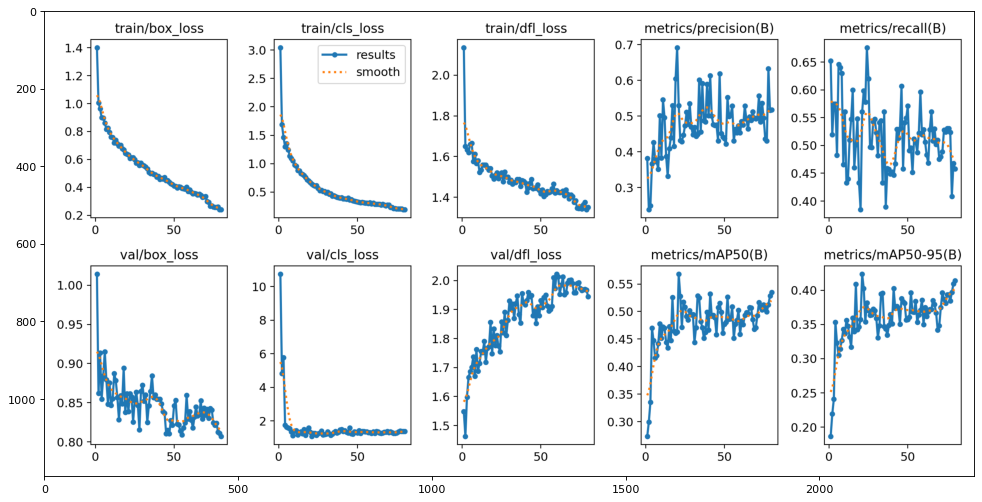

In [6]:
figure(figsize=(15, 10), dpi=80)
# reading the image
results = img.imread('runs/obb/train/results.png')
# displaying the image
plt.imshow(results)

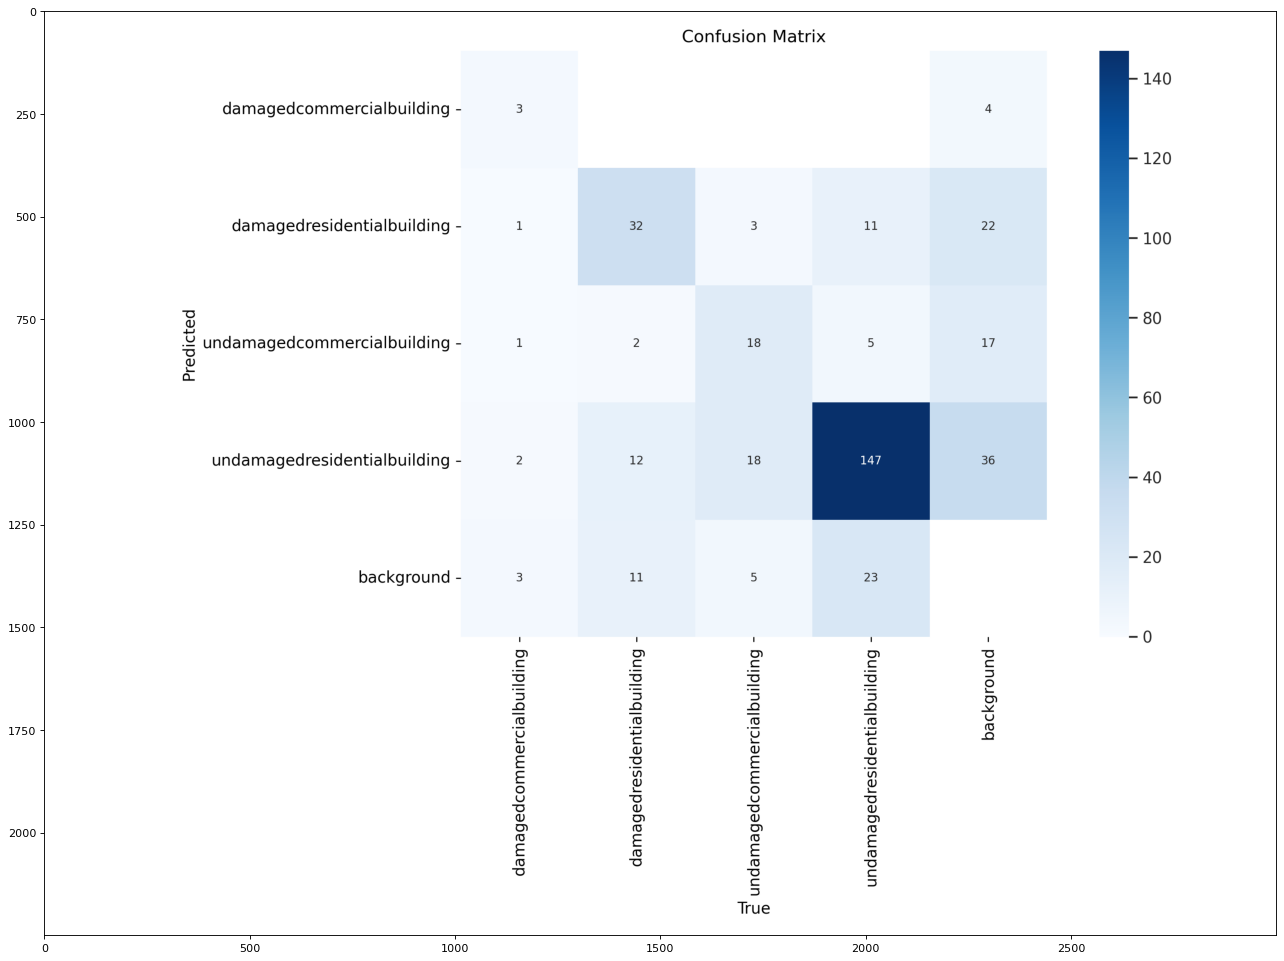

In [7]:
figure(figsize=(20,15), dpi=80)
# reading the image
cf = img.imread('runs/obb/train/confusion_matrix.png')
# displaying the image
plt.imshow(cf)

### Download submission images from platform

In [8]:
def unzip_folder(zip_filepath, dest_dir):
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)
    print(f'The zip file {zip_filepath} has been extracted to the directory {dest_dir}')



submission_zip = './challenge_1_submission_images.zip'
submission_directory = './challenge_1_submission_images'
unzip_folder(submission_zip,submission_directory)

The zip file ./challenge_1_submission_images.zip has been extracted to the directory ./challenge_1_submission_images


### Making Predictions on the Submission Data

In [9]:
# Load the Model
model = YOLO('runs/obb/train/weights/best.pt')

In [10]:
# Decoding according to the .yaml file class names order
decoding_of_predictions ={0: 'damagedcommercialbuilding', 1: 'damagedresidentialbuilding', 2: 'undamagedcommercialbuilding', 3: 'undamagedresidentialbuilding'}
directory = 'challenge_1_submission_images/Submission data'
# Directory to store outputs
results_directory = 'Validation_Data_Results'

# Create submission directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the current object is a file and ends with .jpeg
    if os.path.isfile(os.path.join(directory, filename)) and filename.lower().endswith('.jpg'):
        # Perform operations on the file
        file_path = os.path.join(directory, filename)
        print(file_path)
        print("Making a prediction on ", filename)
        results = model.predict(file_path, save=True, iou=0.5, save_txt=True, conf=0.25)

        for r in results:
            conf_list = r.obb.conf.cpu().numpy().tolist()
            clss_list = r.obb.cls.cpu().numpy().tolist()
            original_list = clss_list
            updated_list = []
            for element in original_list:
                 updated_list.append(decoding_of_predictions[int(element)])

        bounding_boxes = r.obb.xyxy.cpu().numpy()
        confidences = conf_list
        class_names = updated_list

        # Check if bounding boxes, confidences and class names match
        if len(bounding_boxes) != len(confidences) or len(bounding_boxes) != len(class_names):
            print("Error: Number of bounding boxes, confidences, and class names should be the same.")
            continue
        text_file_name = os.path.splitext(filename)[0]
        # Creating a new .txt file for each image in the submission_directory
        with open(os.path.join(results_directory, f"{text_file_name}.txt"), "w") as file:
            for i in range(len(bounding_boxes)):
                # Get coordinates of each bounding box
                left, top, right, bottom = bounding_boxes[i]
                # Write content to file in desired format
                file.write(f"{class_names[i]} {confidences[i]} {left} {top} {right} {bottom}\n")
        print("Output files generated successfully.")


challenge_1_submission_images/Submission data/Validation_Post_Event_010.jpg
Making a prediction on  Validation_Post_Event_010.jpg

image 1/1 /home/jovyan/challenge_1_submission_images/Submission data/Validation_Post_Event_010.jpg: 640x640 101.3ms
Speed: 2.3ms preprocess, 101.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/obb/predict
1 label saved to runs/obb/predict/labels
Output files generated successfully.
challenge_1_submission_images/Submission data/Validation_Post_Event_008.jpg
Making a prediction on  Validation_Post_Event_008.jpg

image 1/1 /home/jovyan/challenge_1_submission_images/Submission data/Validation_Post_Event_008.jpg: 640x640 54.9ms
Speed: 1.8ms preprocess, 54.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/obb/predict
2 labels saved to runs/obb/predict/labels
Output files generated successfully.
challenge_1_submission_images/Submission data/Validation_Post_Event_006.jpg
Making a pr

In [11]:
# Define your source directory and the destination where the zip file will be created
source_dir = results_directory
destination_zip = 'submission'

# Create a zip file from the directory
shutil.make_archive(destination_zip, 'zip', source_dir)

print(f"Directory {source_dir} has been successfully zipped into {destination_zip}.")

Directory Validation_Data_Results has been successfully zipped into submission.
